---
title: Newton's Method
author: Caitlin Baxter
date: '2023-05-01'
description: "Implementing Newton's Method"
format: html
---

In [31]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression
from logistic import NewtonOptimizer
from logistic import GradientDescentOptimizer
from matplotlib import pyplot as plt
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Abstract
In this blog post I used an implementation of Newton's Method to optimize my previously constructed Logistic Regression model. It was demonstrated through experimentation that a Logistic Regression model using Newton's Method will converge to a weight vector that allows for the proper descision boundary for linearly seperable data, and that it can do it in fewer iterations than standard gradient descent. However when the learning rate is too large, it will fail to converge. I then analyzed the computational cost of Newton's method compared to standard gradient descent and determined that with a large number of features, the computational expense of Newton's Method might make it a less desirable optimizer as opposed to standard gradient descent, despite its speed. It was determined that when the learning rate is increased too much, the model fails to converge.

## Part A: Implement Newton's Method

Here is my implementation of [Newton's Method](https://github.com/cbbaxter/cbbaxter.github.io/blob/4e221ee92fc23192978b07b6a751c0e8df647e61/posts/newtons-method/logistic.py) with Newton's Method.

In the following code chunk, I include functions by Professor Phil Chodrow that I use throughout the blog post to initialize and plot my data.

In [32]:
import torch
torch.manual_seed(123)

def classification_data(n_points, noise, p_dims):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

# Code modifies from Prof. Chodrow's "plot perceptron data"
def plot_logistic_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# Code by Prof. Chodrow
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)



## Part B: Perform Experiments
### 1. Chosing an appropriate value of $\alpha $

To begin this experiment, we first initialize 500 random data points and initialized the Logistic Regression model with an $\alpha$ of 10. I ran the training loop for 1000 iteration (or until the loss converged at zero).

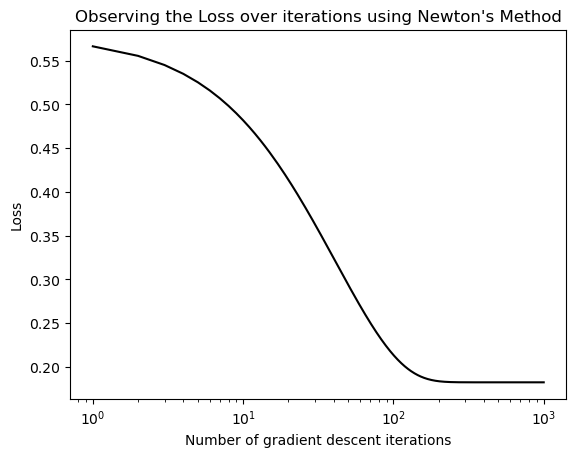

In [33]:
torch.manual_seed(123)

X, y = classification_data(500, 0.5, p_dims = 2)

LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

# for keeping track of loss values
loss_vec = []
alpha = 10 # sufficiently small
max_iter = 1000
curr_iter = 0

loss = LR.loss(X, y) 

while curr_iter < max_iter and loss > 0:

    loss = LR.loss(X, y) 
    loss_vec.append(loss)

    opt.step(X, y, alpha)
    
    curr_iter += 1

    final_w = torch.clone(LR.w)



plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss", title="Observing the Loss over iterations using Newton's Method")



By visualizing the loss vector over the iterations we can see that the loss converges at a value of approximately 0.2 after about 100 iterations. 

(-2.0, 4.0)

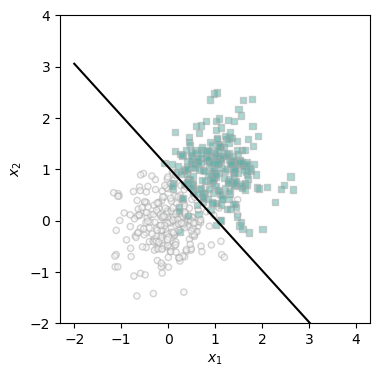

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_logistic_data(X, y, ax)
draw_line(final_w, x_min = -2, x_max = 4, ax = ax, color = "black")
ax.set_ylim(-2, 4)

 When we then plot the values of w as the decision boundary we observe that it seems to split the data into the two intended sections. 

### 2. Experimenting with the Rate of Convergence


To compare the rate of convergence between Newton's Method and Standard Gradient Descent, I ran my logistic regression model again on the same data this time using SGD as the optimization step.

In [35]:

torch.manual_seed(123)

LR = LogisticRegression()
opt_standard_grad = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec_grad = []
alpha = 0.1 
beta = 0.0
max_iter = 2000
curr_iter = 0

loss = LR.loss(X, y) 

while curr_iter < max_iter and loss > 0:

    loss = LR.loss(X, y) 
    loss_vec_grad.append(loss)

    opt_standard_grad.step(X, y, alpha, beta)
    
    curr_iter += 1

    if curr_iter == max_iter:
        final_w = torch.clone(LR.w)

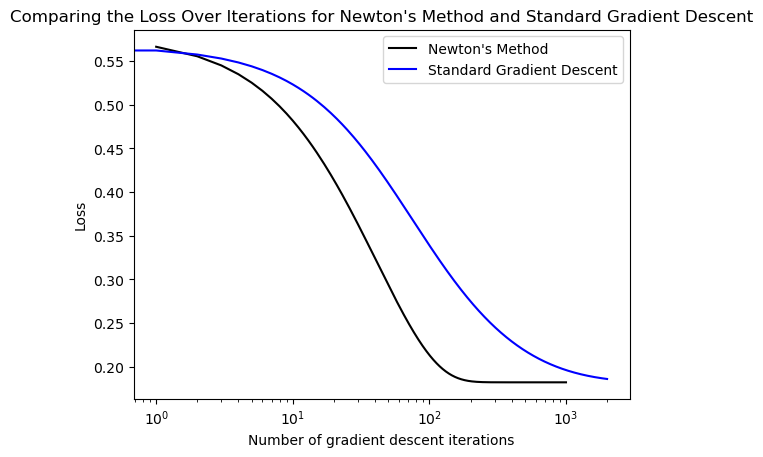

In [36]:

plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black", label = "Newton's Method") 
plt.plot(loss_vec_grad,  label = "Standard Gradient Descent", color = "blue")
plt.semilogx()
plt.legend()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss", title = "Comparing the Loss Over Iterations for Newton's Method and Standard Gradient Descent")


I then plotted the evolution of the loss of both models across the iterations. As evident in this plot, Newton's method converges much more quickly than standard gradient descent.

### 3. If $\alpha $ is too large, Newton's method fails to converge

In order to test what would happen with a very large learning rate, I again used Logistic Regression on the same data, this time with an alpha of 1025.

[tensor(0.3366), tensor(0.4769), tensor(1.1496), tensor(9.3413), tensor(nan)]

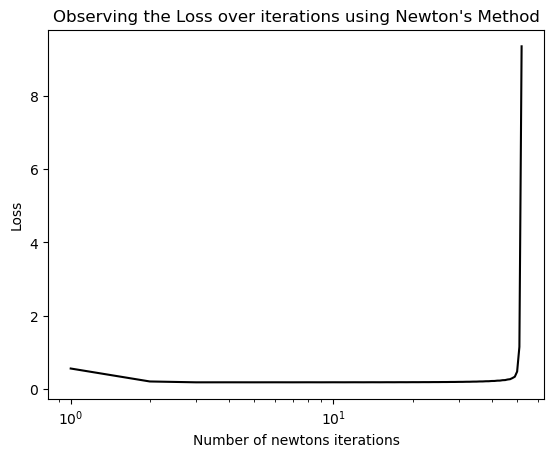

In [43]:

LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

loss_vec_large_a = []
alpha = 1025
max_iter = 1000
curr_iter = 0

loss = LR.loss(X, y) 

while curr_iter < max_iter and loss > 0:

    loss = LR.loss(X, y) 
    loss_vec_large_a.append(loss)

    opt.step(X, y, alpha)
    
    curr_iter += 1

    if curr_iter == max_iter:
        final_w = torch.clone(LR.w)


plt.plot(torch.arange(1, len(loss_vec_large_a)+1), loss_vec_large_a, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of newtons iterations", ylabel = "Loss", title="Observing the Loss over iterations using Newton's Method")

loss_vec_large_a[-5:]



As shown in this graph and the output of the loss vector, before the loss value becomes NaN, it begins to increase indicating that Newton's Method is not behaving as it should with such a large learning rate. 

## Part C: Operation Counting

Suppose that, given a computation unit $c$ and a matrix of $p \times p$:

- It costs $c$ to compute the loss, $L$
- It costs $2c$ to compute the gradient $\nabla L$
- It costs $pc$ o compute the Hessian
- It costs $k_1 p^\gamma$ to invert a $p \times p$ matrix
- It costs $k_2 p^2$ to perform the matrix vector multiplication required by Newton's method
- Newton's method converges to an adequate solution in $t_\mathrm{nm}$
- Gradient Descent converges to an adequate solution in $t_\mathrm{gd}$ steps

We are able to write expressions describing the total computation costs of Newton's method as compared to gradient descent.

$$ \begin{aligned} O(\text{Gradient Descent}) &= L + t_\mathrm{gd} \times \nabla L \\ &=  c + t_\mathrm{gd} \times 2c  \end{aligned}$$

$$ \begin{aligned} O(\text{Newton's Method}) &= L + t_\mathrm{nm} \times (\nabla L + \text{Hessian} + \text{invert} + \text{Matrix-vector Multiplication})
\\ &= c + t_\mathrm{nm} \times (2c + pc + k_1 p^\gamma + k_2 p^2) \end{aligned}$$

In order to determine how any fewer iterations of Newton's method would require less computational power, I compared these two equations. 

$$ \begin{aligned}
O(\text{Gradient Descent}) &> O(\text{Newton's Method}) \\
c + 2t_{gd}c &> c + t_{nm}*(2c + pc + k_1p^\gamma + k_2p^2) \\
2t_{gd}c &> t_{nm}*(2c + pc + k_1p^\gamma + k_2p^2) \\
t_{gd} &> t_{nm}*(1 + \frac{p}{2} + \frac{k_1p^\gamma}{2c} + \frac{k_2p^2}{2c})
\end{aligned} $$

As demonstrated in this inequality, in order for Newton's method to be less computationally expensive than standard gradient descent, $t_{nm}$ must be smaller than $t_{gd}$ by a factor of $(1 + \frac{p}{2} + \frac{k_1p^\gamma}{2c} + \frac{k_2p^2}{2c})$. 

Assuming that p is a very large value we can simplify this equation to the following As $ 2 \le \gamma < 3$.

$$ t_{gd} > t_{nm} \times O(p^\gamma) $$

This means that when $p$ is very large it greatly increases the computational expense of Newton's Method, and its speed might not be worth its complexity as opposed to standard gradient descent.


## Conclusion

In this blog post I was able to implement Newton's Method as an optimizer for my implementation of Logistic Regression. Through experimentation, I demonstrated that it was able to converge faster than standard gradient descent, but later showed that when the number of features is very large it greatly increases the computational expense. I also demonstrated that with very high learning rates, the model begins to diverge. Through this investigation I was able to access the benefits and risks of Newton's Method for optimization. 